# Create a time series forecasting model with CrateDB, PyCaret and MLflow

This notebook guides you through the process of creating a time series
machine learning model with CrateDB and PyCaret. The exciting part will be
to use automatic machine learning model selection, benchmarking and
hyperparameter tuning - commonly known as AutoML.

The notebook uses a sales data dataset and will forecast probable future sales.

## CrateDB

CrateDB is a distributed SQL database that makes it simple to store and analyze
huge amounts of time series data in real-time. It provides a robust SQL
interface and a number of analytics features that are well suited for machine
learning tasks.

Two additional features stand out:

1. CrateDB allows to store both relational data like strings, floats and
   timestamps, as well as complex object types. This makes it easy to store
   the raw data required for machine learning model creation as well as the
   metadata that is often required to make sense of the data.

2. CrateDB offers first-class time-partitioning support. This allows to store
   tremendous amounts of data in a single table and still be able to query
   it in a performant way. This is especially useful for time series data
   like sensor data, user tracking data, or log data.

## PyCaret

PyCaret is a Python library that makes it easy to create and train machine
learning models in Python. The outstanding features of PyCaret are its AutoML
capabilities.

PyCaret is a high-level interface on top of popular machine learning frameworks.
Amongst them are scikit-learn, xgboost, ray, lightgbm, and many more. Therefore,
they provide a wide range of models for time series forecasting: ARIMA, SARIMA,
catboost, prophet, and many more.

PyCaret provides a universal interface to utilize these libraries without
needing to know the details of the underlying model architectures and
parameters.

The general concept of PyCaret - and for the matter of fact for AutoML in
general - is rather simple: One takes the raw data, splits it into a training
and a test set and then trains a number of different models on the training
set. The models are then evaluated on the test set and the best performing
model is selected. This process gets repeated for tuning the hyperparameters
of the best models. Again, this process is highly empirical. The parameters are
changed, the model is retrained and evaluated again. This process is repeated
until the best performing parameters are found.

Modern algorithms for executing all these experiments are - amongst others -
GridSearch, RandomSearch and BayesianSearch. For a quick introduction into
these methods, see [Introduction to hyperparameter tuning].

In the past, all these trial-and-error experiments had to be done manually -
which is a tedious and time-consuming task. PyCaret automates this process
and provides a simple interface to execute all these experiments in a
straightforward way. This notebook shows how.

## The dataset

The dataset used to demonstrate the use of PyCaret and CrateDB for training
time series forecasting models is a real-world sales data dataset, to be found
at [data.4tu.nl].

This dataset contains two .csv files that can be used as a new benchmark data 
for the solving of real-world sales forecasting problem. All data are real and 
obtained experimentally in production environment in one of the biggest retail 
company in Bosnia and Herzegovina.
The available data in this dataset are in period from 2014/03/01 to 2021/03/01. 
Data are aggregated on monthly basis.

Dataset `1_target_ts.csv` contains information about actual sales:

- **item**: A unique numerical identifier for each product or item being sold.
- **org**: The numerical code representing the specific organization or branch 
  that made the sale.
- **date**: The date of the sale, formatted as YYYY-MM-DD, indicating precise 
  tracking on a daily basis.
- **quantity**: The number of items sold, recorded as a floating-point number.

Dataset `1_related_ts.csv` contains information about sales prices:

- **item**: A unique numerical identifier for each product or item being sold.
- **org**: The numerical code representing the specific organization or branch 
  that made the sale.
- **date**: The date of the sale, formatted as YYYY-MM-DD, indicating precise 
  tracking on a daily basis.
- **unit_price**: The price of the item sold, recorded as a floating-point 
  number.

[data.4tu.nl]: https://data.4tu.nl/articles/dataset/Real-world_sales_forecasting_benchmark_data_-_Extended_version/14406134/1
[Introduction to hyperparameter tuning]: https://medium.com/analytics-vidhya/comparison-of-hyperparameter-tuning-algorithms-grid-search-random-search-bayesian-optimization-5326aaef1bd1

## Getting started

First, install the required dependencies. 

```bash
pip install -r requirements.txt
```

**Note:** As of time of this writing, PyCaret requires Python 3.8, 3.9 or 3.10.

Second, you will need a CrateDB instance to store and serve the data. The 
easiest way to get started is to use the free CrateDB cloud offering. You can 
sign up for a free account at https://console.cratedb.cloud and 
[deploy a cluster].

To populate your environment with corresponding database access credentials,
create an `.env` file with the following content:

```env
CRATE_HOST=<your-crate-host> # set this to localhost if you're running crate locally
CRATE_USER=<your-crate-user> # set this to crate if you're running crate locally
CRATE_PASSWORD=<your-crate-password> # set this to "" if you're running crate locally
CRATE_SSL=true # set this to false if you're running crate locally
```

You can find your CrateDB credentials in the [CrateDB Cloud Console].

[CrateDB Cloud Console]: https://cratedb.com/docs/cloud/en/latest/reference/overview.html#cluster
[deploy a cluster]: https://cratedb.com/docs/cloud/en/latest/tutorials/deploy/stripe.html#deploy-cluster


## Importing modules

In [2]:
import pandas as pd
import sqlalchemy as sa
import os
import plotly
import plotly.graph_objects as go
import mlflow_cratedb  # Required to enable the CrateDB MLflow adapter.
from dotenv import load_dotenv

from pycaret.time_series import setup, compare_models, tune_model,\
    blend_models, finalize_model, save_model, predict_model, plot_model

if os.path.isfile("./.env"):
    load_dotenv("./.env", override=True)

/home/andreas/miniconda3/envs/test_crate/lib/python3.10/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/andreas/miniconda3/envs/test_crate/lib/python3.10/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
2023/11/13 08:16:51 INFO mlflow: Amalgamating MLflow for CrateDB


## Creating demo data

To follow along the demonstration in this notebook, let's first add some demo
data to our crate database. The following snippet will create a table called
`sales_data_for_forecast` with both the target and related dataset being joined
to a single dataset.
Additionally, a column `total_sales` is added which is simply the multiplication
of the number of items sold and the unit price.

In [3]:
target_data = pd.read_csv(
    "https://data.4tu.nl/file/539debdb-a325-412d-b024-593f70cba15b/a801f5d4-5dfe-412a-ace2-a64f93ad0010"
)
related_data = pd.read_csv(
    "https://data.4tu.nl/file/539debdb-a325-412d-b024-593f70cba15b/f2bd27bd-deeb-4933-bed7-29325ee05c2e",
    header=None,
)
related_data.columns = ["item", "org", "date", "unit_price"]
data = target_data.merge(related_data, on=["item", "org", "date"])
data["total_sales"] = data["unit_price"] * data["quantity"]
data["date"] = pd.to_datetime(data["date"])

# Insert the data into CrateDB
dburi = f"crate://{os.environ['CRATE_USER']}:{os.environ['CRATE_PASSWORD']}@{os.environ['CRATE_HOST']}:4200?ssl={os.environ['CRATE_SSL']}"
engine = sa.create_engine(dburi, echo=os.environ.get("DEBUG"))

with engine.connect() as conn:
    data.to_sql(
        "sales_data_for_forecast",
        conn,
        index=False,
        chunksize=1000,
        if_exists="replace",
    )

    # Refresh table to make sure the data is available for querying - as CrateDB
    # is eventually consistent
    conn.execute(sa.text("REFRESH TABLE sales_data_for_forecast;"))

## Model creation

Now that the data and environment is set up, we can start creating the model.
As an easy first step, let's load the data we want to use in our model training
environment.


In [4]:
query = """
    SELECT
        DATE_TRUNC('month', DATE) AS MONTH,
        SUM(total_sales) AS total_sales
    from sales_data_for_forecast
    group by month
    order by month
"""

with engine.connect() as conn:
    with conn.execute(sa.text(query)) as cursor:
        data = pd.DataFrame(cursor.fetchall(), columns=cursor.keys())

data["month"] = pd.to_datetime(data['month'], unit='ms')

# We set the MLFLOW_TRACKING_URI to our CrateDB instance. We'll see later why
os.environ["MLFLOW_TRACKING_URI"] = f"{dburi}&schema=mlflow"

Next, let's have a glance on how the dataset looks like, by plotting it.
The feature to be predicted is the `total_sales` column.

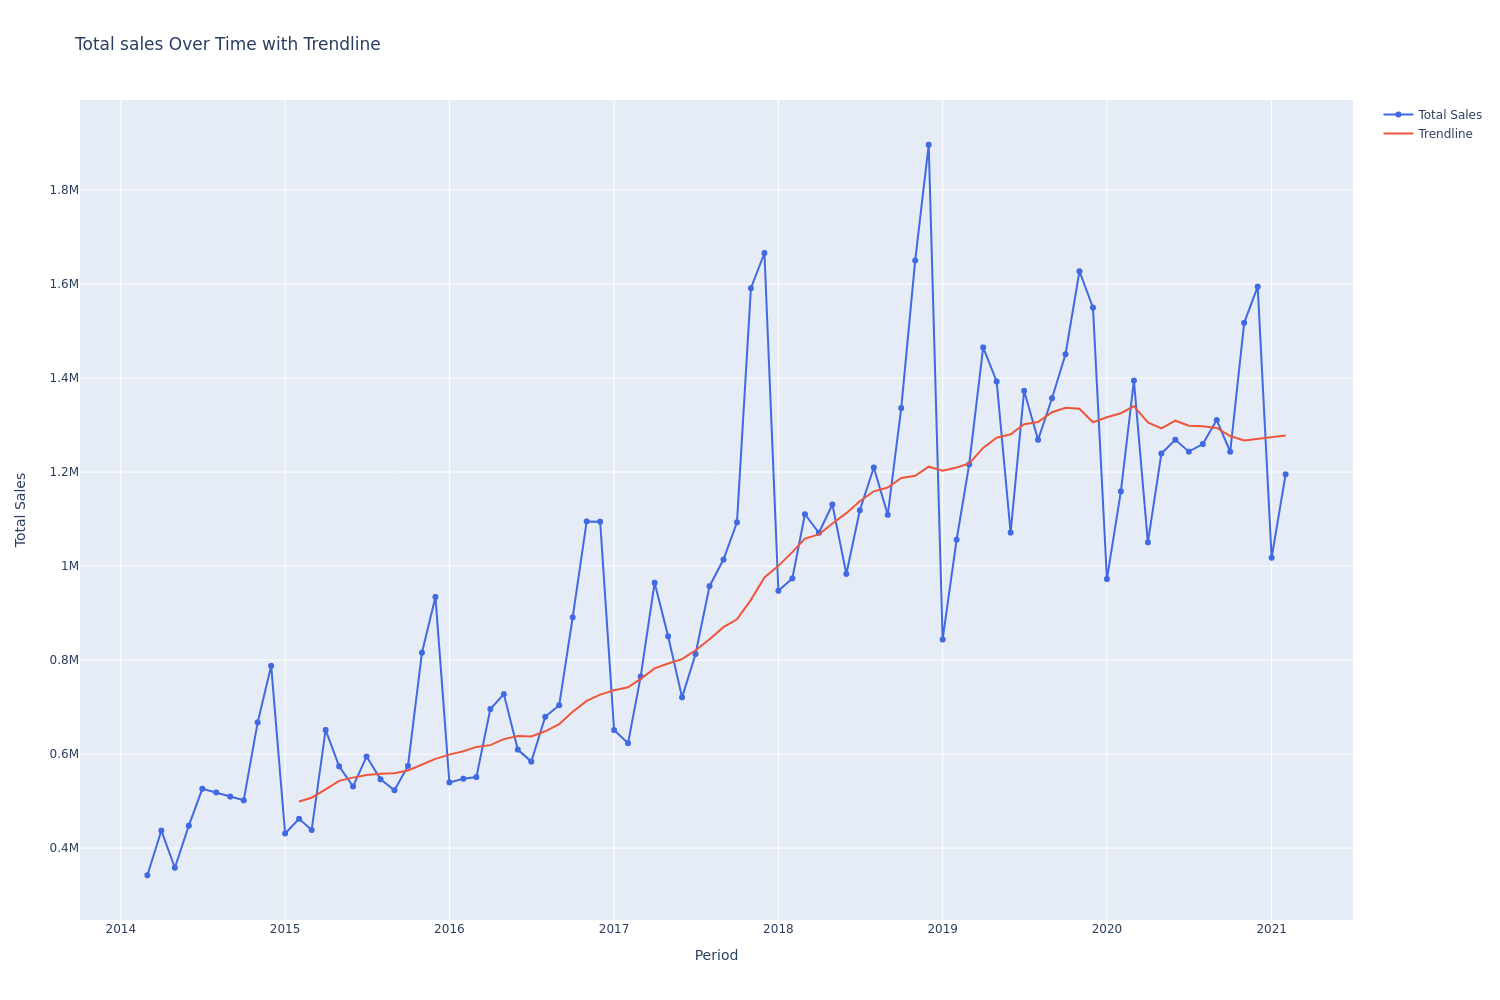

In [5]:
# Set plotly to PNG render mode, to render static PNGs instead of interactive plots.
# Note: Remove this line to get back interactivity.
plotly.io.renderers.default = 'png'

df = data.copy()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df["month"], y=df["total_sales"], mode='lines+markers', name='Total Sales'))

fig.update_traces(line=dict(color='royalblue', width=2), selector=dict(mode='lines+markers'))
fig.add_trace(go.Scatter(x=df["month"], y=df["total_sales"].rolling(window=12).mean(),
                         mode='lines', name='Trendline'))
fig.update_layout(title="Total sales Over Time with Trendline",
                  xaxis_title="Period",
                  yaxis_title="Total Sales",
                  height=1000,
                  width=1500)

fig.show()


The plot reveals some interesting insights about the sales operation of the 
company in question.

**Sales Fluctuations**: The blue line represents the total sales, and it shows 
considerable fluctuations throughout the period. There are notable peaks and 
troughs, suggesting periods of high sales followed by periods of lower sales.

**General Trend**: The orange trendline provides an overview of the general 
sales trend over the years. It appears that there's a gradual upward trend in 
sales from 2014 to 2021. This indicates that, despite the periodic fluctuations,
the overall sales have been on the rise over the years.

**Noteworthy Observations**:
- **Rapid Growth in Early Years**: Sales seem to have started at a relatively 
  lower point in 2014 but saw rapid growth, reaching a peak in 2015.
- **Stability Post-2017**: Post-2017, the total sales seem to stabilize 
  somewhat, with the fluctuations being less drastic compared to the previous 
  years.
- **Sales in 2020**: There's a noticeable dip in sales in 2020, possibly 
- indicative of external factors affecting the market (e.g., economic downturns,
-  global events, etc.).
- **Recovery in 2021**: Despite the dip in 2020, sales appear to be on the 
- recovery path in 2021, suggesting a positive outlook for the future.

### Time series observations
When analyzing the chart from a time series perspective, we can make the
following observations:

- **Trend**: Trend represents a consistent upward or downward slope of the data
  over time. In the provided chart, there's a clear upward trend observed
  through the orange trendline, indicating an overall increase in sales from 
  2014 to 2021. The trend is more horizontal after 2021.
- **Seasonality**: This is a repeating pattern or cycle in the data observed 
  at regular intervals. While the chart shows fluctuations, it's not entirely 
  clear if there's a consistent repeating pattern year after year, suggesting 
  that there might be no strong seasonality or the data points are not granular 
  enough to reveal it.
- **Cyclic Patterns**: These are long-term patterns that aren't fixed, unlike 
  seasonality. They might result from economic conditions or other broader 
  factors. The chart might hint at a cyclic pattern, especially with the sharp 
  dip in 2020 followed by a recovery in 2021, but more data or context would be 
  needed to confirm this. (Covid did most probably have an impact on the sales)
- **Irregular Fluctuations (Noise)**: These are random or unpredictable
  movements in the series, not attributed to the trend, seasonality, or cyclic 
  patterns. The chart exhibits irregular fluctuations, especially with the sharp
  peaks and troughs in sales over the years.
- **Level**: It's the baseline value for the series if there were no trend,
  seasonality, or cycles. In this chart, the level can be considered as the 
  starting point in 2014 or the average value over the entire period.

Summarizing these observations, it's quite a complex time series with a 
noticeable trend, irregular fluctuations, and possibly a cyclic pattern.

## Model training

Pycaret will be used to train a model which will forecast sales data based on
the provided historic time series. PyCaret will automatically select the
best performing model class and tune the hyperparameters.

As a first step, one needs to set some high-level parameters for the model
training process. These parameters are set in the `setup` function - and are as
follows.

- Target the `total_sales` column. That is the feature you want to predict.
- The `month` column is used as index (which is the time base column for the 
  time series data). If the dataframe itself has an index, which is a datetime
  column, this parameter can be omitted.
- `log_experiment` is set to `True` to log the experiment to MLflow. This is
  optional, more on that in the later parts of this notebook.
- `fh` is the forecast horzizon and is set to `12` to forecast the next 12 months.
  (The parameter is relativ to the time base column, which is `month` in this
  demo)

In [6]:
s = setup(data, fh=15, target="total_sales", index="month", log_experiment=True)

,Description,Value
0,session_id,2475
1,Target,total_sales
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(84, 1)"
5,Transformed data shape,"(84, 1)"
6,Transformed train set shape,"(69, 1)"
7,Transformed test set shape,"(15, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


When invoking `setup`, PyCaret automatically creates a training and a test 
dataset. 

Next, we can compare different models and see which one performs best. Pycaret
actually compares 28 models and provides the benchmark values for each of them.
We can define which metric is used for the comparison. 
[MASE] is a good metric for forecasting.

[MASE]: https://en.wikipedia.org/wiki/Mean_absolute_scaled_error

In [8]:
# Invoke PyCaret's main workhorse function, `compare_models`.

# - "sort" defines which metric is used to rate the models.
# - "n_select" defines how many models are selected.
# - "exclude" optionally defines which models are excluded from the comparison.
# - "include" optionally defines which models are included in the comparison. (
#    all available models are included by default)
# - "fold" defines the number of folds to use for cross-validation.

if "PYTEST_CURRENT_TEST" in os.environ:
    best_models = compare_models(sort="MASE",
                                 include=["arima", "ets", "exp_smooth"],
                                 n_select=3)
else:
    best_models = compare_models(sort="MASE", n_select=3)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.8179,0.8995,114405.2103,147362.1925,0.1029,0.1074,0.5573,0.2300
ets,ETS,0.8491,0.8963,115510.1155,143774.8587,0.1079,0.1131,0.5743,0.0267
exp_smooth,Exponential Smoothing,0.8912,0.9243,119009.8151,144801.2536,0.1124,0.1201,0.5261,0.3633
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9041,0.9551,128108.1343,158571.6604,0.1137,0.1192,0.4953,0.0967
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9048,0.9932,128928.4659,165701.2714,0.1127,0.1197,0.4482,0.1300
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.9094,0.9455,125712.6457,152986.1263,0.1159,0.1210,0.5215,0.1100
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.9110,0.9890,127967.9641,163345.4069,0.1147,0.1187,0.4698,0.1067
stlf,STLF,0.9272,0.9666,131651.2445,160165.8855,0.1201,0.1222,0.4957,0.0167
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.9429,0.9713,132045.7990,157380.9808,0.1184,0.1244,0.4775,0.0867
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.9467,1.0647,132044.6204,173144.0255,0.1180,0.1239,0.3916,0.2367


### Selecting the best models

PyCaret automatically outputs the performance metrics for each benchmarked
model. Judging from the generated output, the Extra Trees w/ Cond. Deseasonalize 
& Detrending model seemst to be the best performing model architecture.

Please note that the discovered numeric values for each of the metrics are not
fully deterministic - meaning they can change from run to run. PyCaret uses
cross-validation to evaluate the models. This means that the training and test 
sets are split into different chunks for each iteration.

This leads to slightly different performance metrics. Cross-validation is
generally a good idea, as it helps to avoid over-fitting.

#### Notes
Cross validation is yet another aspect of training machine learning models
which is often overlooked by beginners. It is automatically taken care of
by PyCaret.

### Verifying
Before continuing, it's best to have a look at the model performance of the
models created by PyCaret. One can use `plot_model` to get a visual
representation of the model performance.

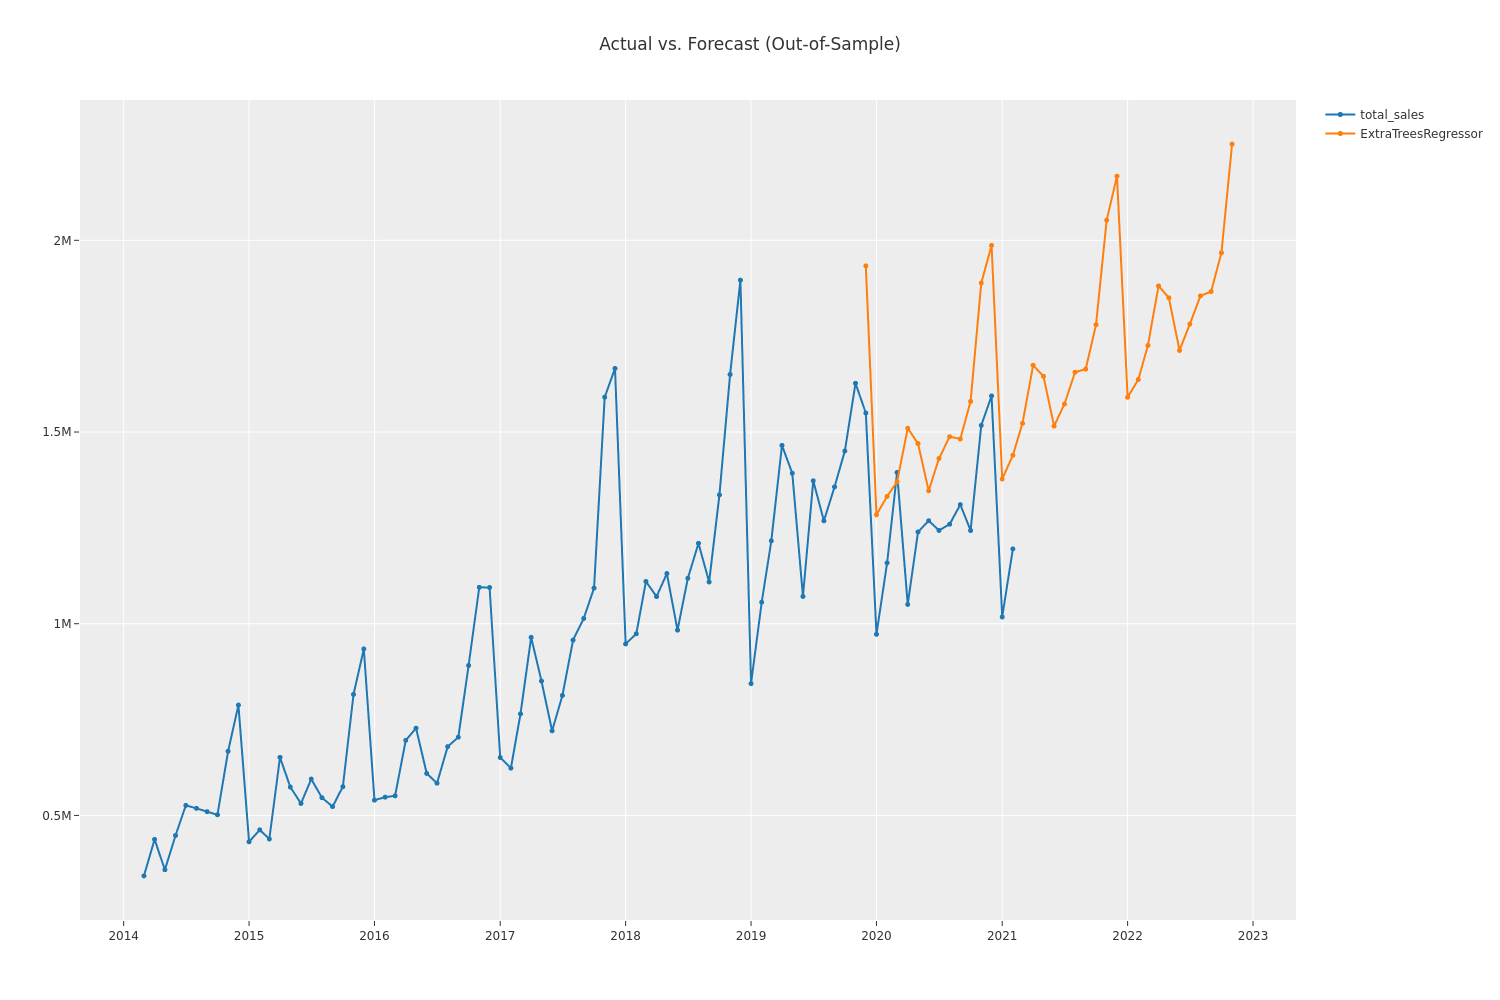

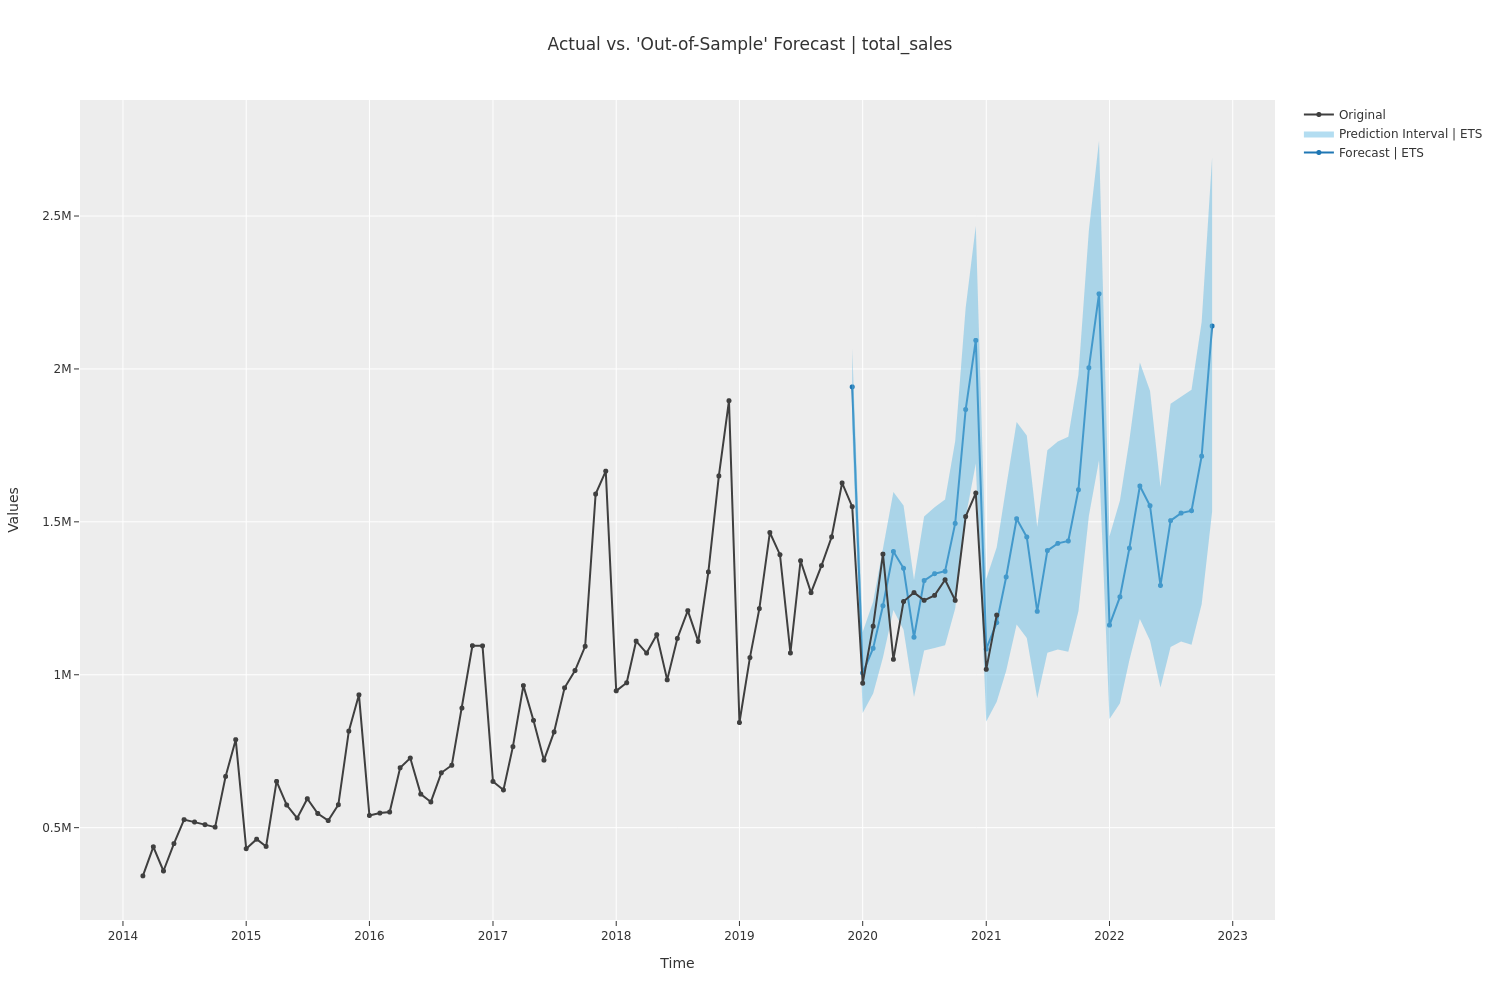

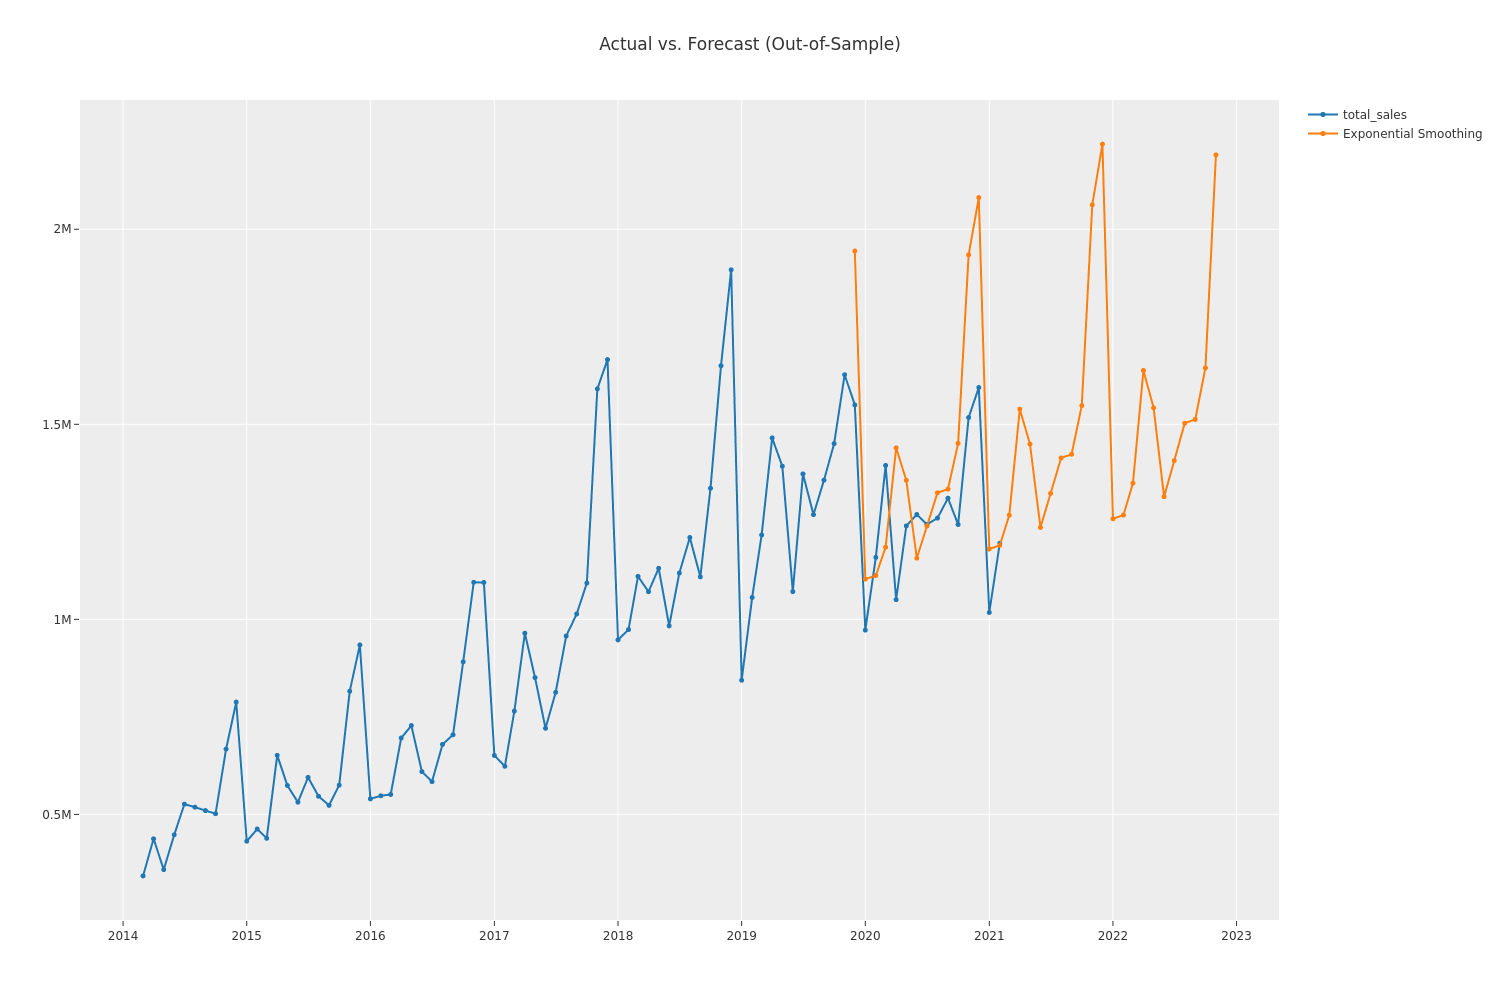

In [20]:
_ = [
    plot_model(
        i,
        plot="forecast",
        data_kwargs={"fh": 36},
        fig_kwargs={"width": 1500, "height": 1000},
    )
    for i in best_models
]

The above plots show that all 3 of the selected models perform quite well, with
the first one - at least on a quick glance - really performing probably best.


### Hyperparameter tuning
However, you are not done yet, another important step is to tune the 
hyperparameters of the winning models, to further improve their performance.

By setting `n_select=3` in the above benchmarking call, you told PyCaret to
select the 3 best performing models from the benchmarking run. You can now use
all 3 of them to tune their hyperparameters. It is quite common that the model
ranking changes after hyperparameter tuning.

Again, hyperparameter tuning in PyCaret is just a single line of code.

#### Notes
PyCaret's `tune_model` function provides a parameter `fold`, which defines
how many folds to use for cross-validation. The default is 10. This means
that the training set is split into 10 chunks and each chunk is used as a
test set once. This is a sane default choice.

To further improve the model performance, it can be increased to 15 or 20.
However, this comes at the cost of increased training time. See [Multiple-k:
Picking the number of folds for cross-validation] for a primer on how folds
impact model performance.

Please do not overthink this aspect. More is better, but with diminishing
returns. 10 is good for almost anything.

[Multiple-k: Picking the number of folds for cross-validation]: https://cran.r-project.org/web/packages/cvms/vignettes/picking_the_number_of_folds_for_cross-validation.html#:~:text=When%20performing%20cross%2Dvalidation%2C%20it,common%20to%20use%2010%20folds

In [10]:
# Run `tune_model` for each model in `best_models`.
tuned_models = [tune_model(model) for model in best_models]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-02,3.3311,3.6679,355634.3558,451826.8338,0.4788,0.3524,-6.0660
1,2017-05,1.4540,1.4727,190778.4769,225271.6534,0.1704,0.1590,0.1367
2,2018-08,0.7812,0.8245,147658.7509,185606.6611,0.1200,0.1122,0.4794
Mean,NaT,1.8554,1.9884,231357.1945,287568.3828,0.2564,0.2079,-1.8166
SD,NaT,1.0790,1.2167,89623.0525,117271.6418,0.1586,0.1040,3.0080


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:    5.0s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.0s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-02,0.7797,0.8350,83245.0885,102853.7873,0.1082,0.1116,0.6338
1,2017-05,1.0942,1.0945,143569.2186,167411.0165,0.1285,0.1367,0.5232
2,2018-08,0.5008,0.4987,94655.3272,112268.0647,0.0737,0.0729,0.8095
Mean,NaT,0.7916,0.8094,107156.5448,127510.9562,0.1034,0.1071,0.6555
SD,NaT,0.2424,0.2439,26165.6326,28474.1785,0.0226,0.0262,0.1179


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-02,nan,nan,nan,nan,nan,nan,nan
1,2017-05,nan,nan,nan,nan,nan,nan,nan
2,2018-08,0.6920,0.6912,130806.8626,155594.8934,0.1013,0.1075,0.6342
Mean,NaT,nan,nan,nan,nan,nan,nan,nan
SD,NaT,nan,nan,nan,nan,nan,nan,nan


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


PyCaret outputs the cross-validation performance metrics for each model.

You might notice that for some models, the metrics for the tuned model are worse than
for the un-tuned model. This is quite common - more often than not, the default model
parameters - especially for rather simple model architectures - are already quite good.
However, there are no indicators for this - so running the hyperparameter tuning is
always a good idea.

Building upon all you have learned, there is one more trick to know about modern ML
approaches: combining multiple models.

For time series model, PyCaret offers model blending as model combination option.

**Note:** As for hyperparameter tuning, combining models does not always lead
to better results. But it is worth a try.

### Blending models

Blending models is a technique that combines multiple models of different
architectures. The idea is to combine the strengths of different models to
achieve better performance. In a nutshell, a meta-learner model is trained
which takes the predictions of the base models as input and outputs the final
prediction. It basically combines the outputs of the base models to a final
prediction.

The example below uses all tuned models as base models. An even better approach
would be to hand-pick the best performing models from all the previous experiments,
but for the sake of brevity, let's stick with the tuned models.

In [11]:
blend = blend_models(estimator_list = tuned_models)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-02,0.6330,0.7023,67585.5723,86510.7892,0.0865,0.0883,0.7410
1,2017-05,1.2737,1.3039,167117.6401,199450.2229,0.1428,0.1564,0.3233
2,2018-08,0.4715,0.4803,89123.2263,108134.6987,0.0713,0.0698,0.8233
Mean,NaT,0.7928,0.8289,107942.1462,131365.2369,0.1002,0.1049,0.6292
SD,NaT,0.3464,0.3479,42757.2367,48946.0407,0.0307,0.0372,0.2189


##  Getting the best model

We have come a long way. You have trained 28 models, tuned their hyperparameters,
and combined them using model blending. The avid reader
might remark, that this was quite a lot of work.

However, one has to keep in mind that all of this was done with just a few lines
of code, and, more importantly, all of this is the same for almost any forecasting
machine learning task - making the approach highly reusable.

The missing step is to identify the best model from all the conducted experiments.
This is done by simply looking the the Mean MASE outputs of all the model training
and tuning steps above. Looking at all the outputs, the best performing model is
the blended model with a MASE of 0.7783.

In [12]:
best_model = blend

PyCaret also provides methods to investigate the model in more detail. The
main tool you want to use for inspecting time series models is `plot_model`.
`plot_model` provides a number of plots that help to understand the model
behavior. The function provides a `plot` parameter which allows to select
the type of plot to be generated. Find the full list of available plots
in the [PyCaret documentation].

[PyCaret documentation]: https://pycaret.readthedocs.io/en/latest/api/time_series.html


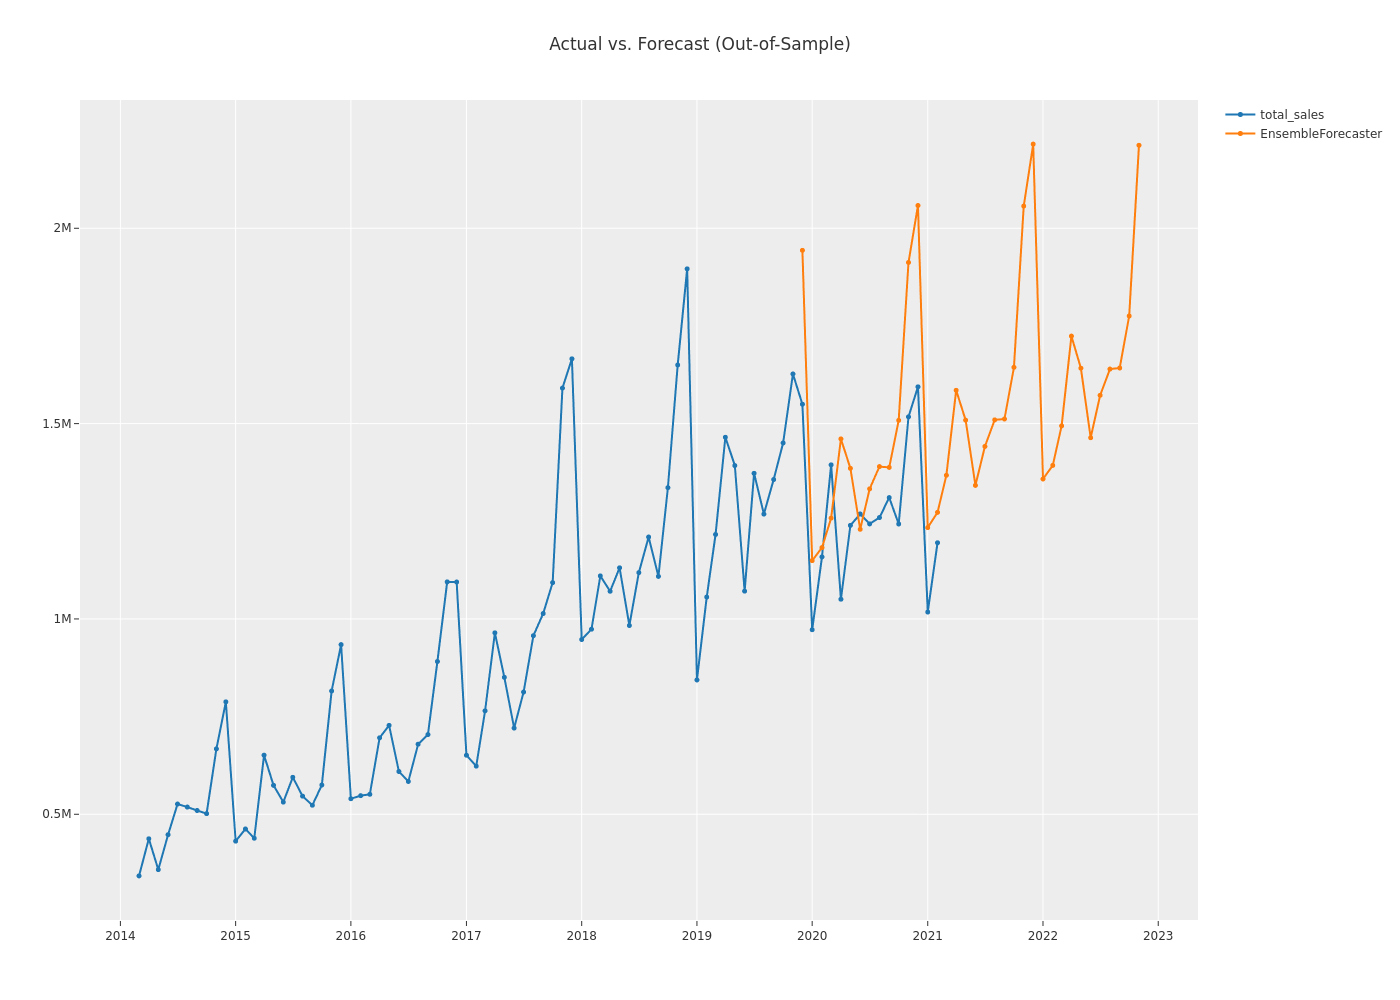

In [13]:
plot_model(best_model, plot = 'forecast', data_kwargs={"fh": 36}, fig_kwargs = {"height": 1000, "width": 1400})

## Finalizing

Up until now, you trained and evaluated the model on the training data -
whereas the input dataset was split in training and test data.

This means, the test data were not used for training the model, which is a good
thing, as you need a test set for validation.

However, now that you know which model works best, you should retrain it on the
whole dataset, to get as many training data as possible. In some cases, this can
improve model quality. For that, PyCaret provides the `finalize_model` method.

In [14]:
final_model = finalize_model(best_model)

## Saving the model

To use this newly built model for predicting new data, you can export it using
either the `deploy_model`, or `save_model` methods. For more details on those,
see [MLOps and deployment related functions in PyCaret].

[MLOps and deployment related functions in PyCaret]: https://pycaret.gitbook.io/docs/get-started/functions/deploy

In [15]:
if not os.path.exists("model"):
    os.makedirs("model")

# Save the model to disk
_ = save_model(final_model, "model/timeseriesforecast_model")

Transformation Pipeline and Model Successfully Saved


## Predictions on unseen data

To use the model for predictions, use the `predict_model` method. This
method takes the model and the data to predict as input, and outputs the
predictions for these new data.

In [16]:
predict_model(final_model, s.X_test)

,y_pred
2021-03,1.393161e+06
2021-04,1.431464e+06
2021-05,1.457675e+06
2021-06,1.282406e+06
2021-07,1.431513e+06
2021-08,1.437997e+06
2021-09,1.397169e+06
2021-10,1.415266e+06
2021-11,1.650740e+06
2021-12,1.679905e+06


## Experiment tracking with MLflow and PyCaret

MLflow is an open source platform for managing the end-to-end machine learning
lifecycle. It is the de facto standard for experiment tracking in the machine
learning community. It provides a simple interface to track experiments,
parameters, metrics and artifacts. It also provides a simple UI to browse
experiments and registered models.

MLflow needs a storage backend to store all these information, and CrateDB offers
exactly that. CrateDB can be used as the main storage engine for the full Machine
Learning lifecycle - from storing the raw data, to storing the experiment and model
metadata.

Last but not least, PyCaret also provides first-class support for MLflow.
This means that all the experiments you've run above are automatically tracked
in MLflow. This is especially useful for production scenarios, where you want
to keep track of all the experiments run and the models created.

As you've seen, a typical training workflow scenario involves running *many*
experiments, being able to automatically track them is a huge time saver.

### Configuring MLflow to use CrateDB

Before you can use CrateDB as a MLflow backend, you will need to configure the
`MLFLOW_TRACKING_URI` environment variable point to the address of the CrateDB
database instance. NB: You probably already did that at the very beginning of
this demo.

In [17]:
os.environ[
    "MLFLOW_TRACKING_URI"
] = f"crate://{os.environ['CRATE_USER']}:{os.environ['CRATE_PASSWORD']}@{os.environ['CRATE_HOST']}:4200?ssl={os.environ['CRATE_SSL']}&schema=mlflow"

Now if you run the previous experiments again, they are tracked in CrateDB using
MLflow.

### Registering trained models

Tracking experiments is one thing, but you also want to keep track of the models
created. For that, use the `log_model` method. This method
takes the trained model and a name as input, and registers the model in MLflow
and subsequently in CrateDB.

Make sure to first run `save_model` as described above.

In [18]:
from mlflow.sklearn import log_model

_ = log_model(
    sk_model=final_model,
    artifact_path="model/timeseriesforecast_model",
    registered_model_name=f"timeseriesforecast_model",
)

Registered model 'timeseriesforecast_model' already exists. Creating a new version of this model...
2023/11/13 08:35:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: timeseriesforecast_model, version 11
Created version '11' of model 'timeseriesforecast_model'.


## Summary

In this demonstration example you explored how to use CrateDB and PyCaret to
train a timeseries forecast machine learning model. Now, you know how to train and
evaluate multiple models, how to tune their hyperparameters, and how to combine
them using ensemble learning and blending models. You've also learned how to use
MLflow to track experiments and how to register trained models.

All these steps used to be a lot of work and required a good amount of know-how
about the entire machine learning ecosystem. One needs to know the available
model architectures, state-of-the-art benchmarking and tuning techniques, and
how to combine models. This is a lot of work and requires a lot of experience.
By using PyCaret, all of this is reduced to a few lines of code. This makes
machine learning applicable for a much broader audience.

While this demo took the chance to explain many details around the model training
process, this is the main code required to train a timeseries forecasting model,
at a glance.

```python
from pycaret.time_series import *
setup(data, fh=15, target="total_sales", index="month", log_experiment=True)
best_models = compare_models(sort="MASE", n_select=3)
tuned_models = [tune_model(model) for model in best_models]
blend = blend_models(estimator_list = tuned_models)

# Compare the MASE values of all experiments and finalize the best model
final_model = finalize_model(best_model)


```

This demo also demonstrated how CrateDB can be utilized as the main storage engine
for end to end machine learning workflows. From storing the raw data to storing the
experiment and model metadata, CrateDB can be used as a single piece of data
infrastructure for the entire model lifecycle.